# AutoML and Hyperparameter Tuning

##### This notebook uses automated machine learning tools (PyCaret) to find suitable models and settings for the snowflake classifiction project.

In [1]:
# Import basic packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Define the file path of the dataset
file_path = '/home/disk/meso-home/vgarcia1/PHIPS_classification/PHIPS_CrystalHabitAI_Dataset.nc'

# Open the NetCDF file using xarray
ds = xr.open_dataset(file_path)


In [ ]:
#!pip install pycaret

/home/disk/meso-home/vgarcia1/.cshrc.local: No such file or directory.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 240.5 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 1.5 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 438.7 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 3.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 712.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 8.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 859.7 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 2.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 773.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 2.9 MB/s eta 0:00:00:00:01
   ━━━━━━━

## 1. Data pre-processing 

In [3]:
# Flatten the image arrays (convert each image from a 2D array to a 1D vector)
image_arrays = np.array([image_array.flatten() for image_array in ds['image_array'].values])

# Scales features in data using statistics that are robust to outliers.
# Before applying PCA (a dimensionality reduction method), it's important to scale the data so that each feature contributes equally to the analysis.

from sklearn.preprocessing import RobustScaler

# Apply Robust Scaling
scaler = RobustScaler()
scaled_data = scaler.fit_transform(image_arrays)

from sklearn.decomposition import PCA

# Apply PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

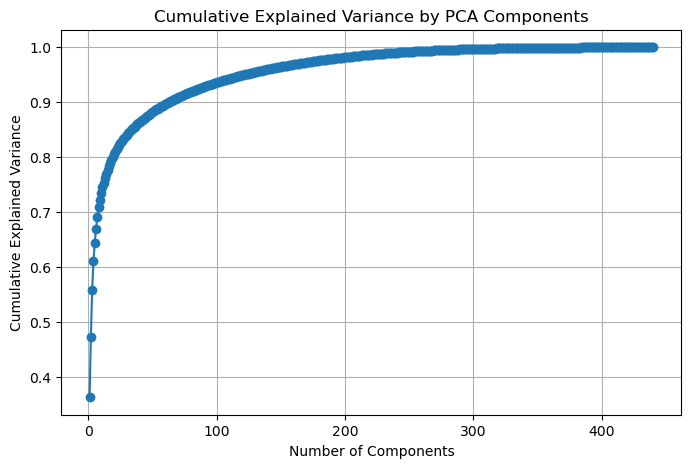

In [4]:
# Plot cumulative explained variance (to determine the number of components to keep)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()

In [5]:
# Determine the minimum number of components to retain 90% of the variance
target_variance = 0.90  # Adjust this threshold as needed
n_components = np.argmax(cumulative_variance >= target_variance) + 1
print(f"Number of components to retain {target_variance * 100}% of the variance: {n_components}")

Number of components to retain 90.0% of the variance: 63


In [6]:
# Apply PCA with the optimal number of components (63 in this case)
pca = PCA(n_components=63)
pca_result = pca.fit_transform(scaled_data)

In [ ]:
# Convert the PCA results into a DataFrame for use in PyCaret
pca_columns = [f'PC{i+1}' for i in range(63)]
pca_df = pd.DataFrame(pca_result, columns=pca_columns)
pca_df['habit_type'] = ds['label'].values  # Adding the target label

## 2. PyCaret setup and model selection

In [11]:
from pycaret.classification import *

clf = setup(
    data=pca_df,
    target='habit_type',
    session_id=42,
    verbose=False,
    fold=5  # Set the number of cross-validation folds here
)

In [17]:
# Compare models to find the best one
# Trains and evaluates multiple classification algorithms using cross-validation and ranks them based on a performance metric (e.g., accuracy, AUC)
best_model = compare_models(include=['rf', 'lr', 'lightgbm', 'svm', 'et', 'ada', 'gbc'] # To reduce computation time, focus on a smaller subset of models known to perform well in classification tasks
                            ) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.3799,0.8313,0.3799,0.4018,0.3621,0.3182,0.3230,1.4800
et,Extra Trees Classifier,0.3574,0.8250,0.3574,0.3587,0.3382,0.2934,0.2976,0.0960
gbc,Gradient Boosting Classifier,0.3539,0.0000,0.3539,0.3519,0.3402,0.2898,0.2925,1.8600
lightgbm,Light Gradient Boosting Machine,0.3507,0.8014,0.3507,0.3534,0.3350,0.2864,0.2897,491.3540
lr,Logistic Regression,0.3347,0.0000,0.3347,0.3197,0.3078,0.2679,0.2725,0.5300
ada,Ada Boost Classifier,0.1950,0.0000,0.1950,0.1075,0.1117,0.1187,0.1598,1.2980
svm,SVM - Linear Kernel,0.1690,0.0000,0.1690,0.1865,0.1439,0.0879,0.0951,0.0640


* **Model:** The name of each model tested, such as Random Forest, SVM, Logistic Regression, etc.

* **Accuracy:** The percentage of correct predictions out of all predictions made, averaged across cross-validation folds.

* **AUC (Area Under the Curve):** The area under the ROC curve, representing the model's ability to distinguish between classes. AUC values closer to 1 indicate better performance.

* **Recall:** The proportion of actual positive cases that were correctly identified by the model. High recall is especially important if you want to minimize false negatives.

* **Precision:** The proportion of positive predictions that were actually correct. High precision indicates that the model has fewer false positives.

* **F1-Score:** The harmonic mean of precision and recall, providing a balance between the two metrics. Useful when you need a single measure of accuracy that accounts for both recall and precision.

* **Kappa:** Cohen's Kappa score, which measures the level of agreement between predictions and actual values, accounting for chance. Higher values mean better agreement.

* **MCC (Matthews Correlation Coefficient):** A balanced measure that takes into account all four confusion matrix categories (true positives, true negatives, false positives, false negatives). MCC values closer to 1 indicate better classification.

* **TT (Sec):** The training time in seconds for each model. Models with lower training times may be preferable if computational efficiency is important.

##### Model Performance Summary
1. Random Forest (rf):
    * Accuracy: 0.3799 (37.99%)
    * AUC: 0.8313 (indicating good separability)
    * Precision: 0.4018
    * F1: 0.3621
    * TT: 1.4800
    * **Interpretation:** Random Forest achieved the highest accuracy and AUC among the tested models. While it has a reasonable AUC, the relatively low accuracy and F1 score indicate it may still struggle with accurate predictions.
2. Extra Trees (et):
    * Accuracy: 0.3574 (35.74%)
    * AUC: 0.8250
    * Precision: 0.3587
    * F1: 0.3382
    * TT: 0.0960
    * **Interpretation:** Extra Trees performed similarly to Random Forest, with slightly lower accuracy, AUC, and F1 scores, but faster training time. This makes it a competitive alternative to Random Forest in terms of time efficiency.
3. Gradient Boosting Classifier (gbc):
    * Accuracy: 0.3539 (35.39%)
    * AUC: 0.0000 (not calculated or unavailable)
    * Precision: 0.3519
    * F1: 0.3402
    * TT: 1.8600
    * **Interpretation:** Gradient Boosting achieved similar performance to Extra Trees but with missing AUC data, suggesting it may be less effective for separating classes in this dataset.
4. LightGBM (lightgbm):
    * Accuracy: 0.3507 (35.07%)
    * AUC: 0.8014
    * Precision: 0.3534
    * F1: 0.3350
    * TT: 491.3540
    * **Interpretation:** LightGBM’s performance is comparable to other tree-based models but is more time-intensive, which could be prohibitive if efficiency is important.
5. Logistic Regression (lr):
    * Accuracy: 0.3347 (33.47%)
    * AUC: 0.0000 (not calculated)
    * Precision: 0.3197
    * F1: 0.3078
    * TT: 0.5300
    * **Interpretation:** Logistic Regression achieved a lower accuracy and F1 than the tree-based models, likely due to the data’s complexity, which linear models struggle with.
6. AdaBoost (ada):
    * Accuracy: 0.1950 (19.50%)
    * AUC: 0.0000
    * Precision: 0.1075
    * F1: 0.1117
    * **Interpretation:** AdaBoost performed poorly, likely due to its use of simpler decision stumps, which may not capture complex patterns in the data.
7. SVM - Linear Kernel (svm):
    * Accuracy: 0.1690 (16.90%)
    * AUC: 0.0000
    * Precision: 0.1865
    * F1: 0.1439
    * **Interpretation:** SVM with a linear kernel had the lowest accuracy, F1, and precision, indicating that the dataset may require a non-linear kernel or model.


In [ ]:
# Tune the hyperparameters of the selected model ()
# Optimizes the hyperparameters of the selected model to improve performance
tuned_model = tune_model(best_model)

print(tuned_model) # Display the tuned model and its hyperparameters

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.3871,0.8380,0.3871,0.3669,0.3600,0.3257,0.3317
1,0.3710,0.8202,0.3710,0.3224,0.3270,0.3087,0.3136
2,0.3065,0.8299,0.3065,0.2898,0.2807,0.2381,0.2446
3,0.3934,0.8359,0.3934,0.4388,0.3617,0.3348,0.3438
4,0.4918,0.8542,0.4918,0.5029,0.4601,0.4400,0.4459
Mean,0.3900,0.8356,0.3900,0.3842,0.3579,0.3295,0.3359
Std,0.0595,0.0111,0.0595,0.0776,0.0590,0.0649,0.0648


Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight={},
                       criterion='entropy', max_depth=7, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.05, min_samples_leaf=4,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=230, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


##### Key Tuned Hyperparameters in RandomForestClassifier
1. `bootstrap=False:`
    *  Indicates that the model is not using bootstrapping (sampling with replacement). By setting it to False, each tree in the forest is trained on the entire dataset instead of a sample, which can sometimes increase variance.

2. `criterion='entropy':`
    * Specifies the criterion used to measure the quality of a split in each tree. Here, entropy is used, which seeks to maximize the information gain.

3. `max_depth=7:`
    * Limits the maximum depth of each tree to 7, controlling the model’s complexity to reduce overfitting.

4. `max_features='sqrt':`
    * Uses the square root of the total number of features as the maximum number of features to consider when looking for the best split, a common setting for Random Forests.

5. `min_impurity_decrease=0.05:`
    * Specifies a minimum threshold for impurity decrease at each split, ensuring splits only occur if they contribute meaningfully to reducing impurity, which may help simplify the model.

6. `min_samples_leaf=4:`
    * Requires at least 4 samples at each leaf node, which helps prevent the model from learning overly specific patterns (reducing overfitting).

7. `n_estimators=230:`
    * The model uses 230 trees in the forest, balancing the trade-off between performance and computational cost.

8. `random_state=42:`
    * Sets a random seed to ensure reproducibility of the results.

## 3. Evaluating the selected model

In [21]:
# Evaluate the model
# Generates evaluation plots and metrics to assess the model's performance
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [26]:
# Retrieve the label encoder mappings from PyCaret's encoded data
label_mapping = dict(enumerate(pca_df['habit_type'].astype('category').cat.categories))
print("Class Label Encoding:", label_mapping)

Class Label Encoding: {0: 'aggregate', 1: 'bullet_rosette', 2: 'capped_column', 3: 'column', 4: 'dendrite', 5: 'graupel', 6: 'needle', 7: 'plate', 8: 'polycrystal', 9: 'side_plane', 10: 'tiny'}


##### The confusion matrix from `evaluate_model()` typically shows results based on the average cross-validation performance across folds. High values are on the diagonals indicate that the model is making mostly correct predictions. Having a maximum count of 11 correct predictions suggests that the model struggles overall, possibly due to class overlap or insufficient distinguishing features between certain classes. Relative to the other classes, the random forest classifier appeared to perform the best when predicting the `tiny` and `aggregate` classes, having an accurate prediction count of 11 and 9, respectively. Meanwhile the model struggled the most at identifying the `capped_column` and `side_plane` classes, which both had an accurate prediction count of 0. The model’s relatively higher accuracy with the `tiny` and `aggregate` classes suggests that these classes have more distinctive features relative to other classes. This could mean that the patterns or characteristics in these images are easier for the model to recognize and differentiate. Zero correct predictions for `capped_column` and `side_plane` likely indicate that the features in these classes are not distinct enough for the model to differentiate from others. These classes may be visually similar to other classes, or there might be an issue with the feature extraction (e.g., PCA components) capturing enough unique information for these classes.

## Most Promising Models by Criteria

##### **Accuracy:** Random Forest and Gradient Boosting are strong contenders, with RF performing best on classes like `tiny` and `aggregate`.
##### **Interpretability:** Random Forest (via feature importance) and Logistic Regression.
##### **Computational Cost:** Extra Trees (efficient RF alternative) and Logistic Regression.